# Mål

Estimere total strømningshastighet gjennom en strupeventil. 
Total flow, av olje, gas og vann, er `QTOT`

Dataset er markert følgende:
- `CHK`: strupeventil opening - et nummer mellom [0,1]. 0 er lukker, 1 er helt åpen. 
- `PWH`: Trykk upstream fra strupeventilen (skalert)
- `PDC`: trykk downstream fra strupeventilen (skalert)
- `TWH`: temperatur upstream fra strupeventilen (skalert)
- `FGAS`: brøkdel av gass til total strømning,  mellom [0,1]
- `FOIL`: brøkdel av vann til total strømning, mellom [0,1]

Figur:

<img src="well_sensors.png">

### Ingen modell for total strømningshastighet, løsning: Dyp Læring

Med et dyp læring nettverk, skal vi lage en prediksjon:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$


# Framework - Keras

Open-source bibliotek for dyp læring i Python.
Bygget På tensorflow

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


# Dataset

In [59]:
df = pd.read_csv('well_data.csv', index_col=0)
df

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
0,0.540,0.542755,0.211586,0.594760,0.138882,0.861118,32.358228
1,0.540,0.542755,0.211586,0.594760,0.142222,0.857774,32.940225
2,0.894,0.458000,0.222654,0.616555,0.144697,0.855303,48.633042
3,0.894,0.452311,0.222556,0.609029,0.144938,0.855056,48.065657
4,0.894,0.443485,0.221839,0.602488,0.144187,0.855807,47.096656
...,...,...,...,...,...,...,...
3094,0.534,0.462606,0.215561,0.592627,0.128039,0.826061,28.108285
3095,0.534,0.462854,0.216331,0.589506,0.127935,0.825378,28.119254
3096,0.534,0.463855,0.239411,0.594895,0.127857,0.824711,27.875849
3097,0.415,0.498174,0.234317,0.581882,0.129256,0.833875,18.412828


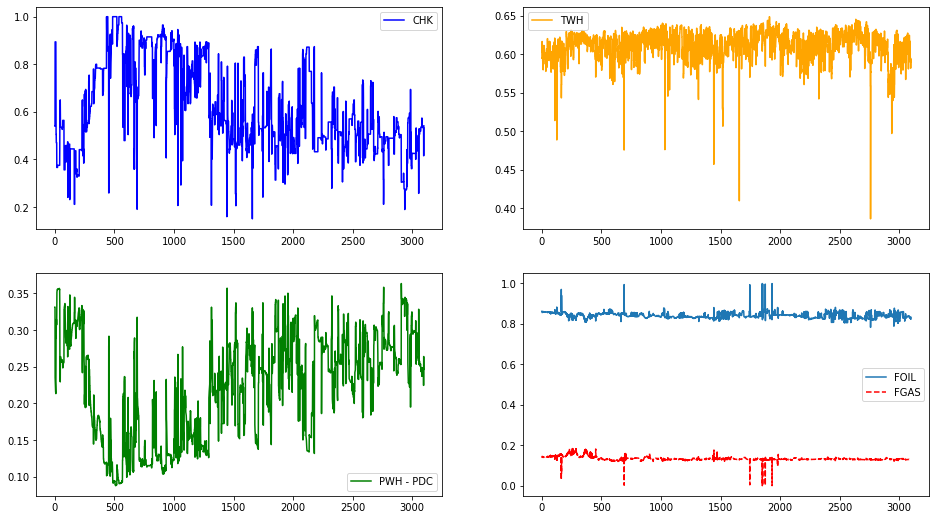

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

## Korrelasjon mellom data

In [61]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


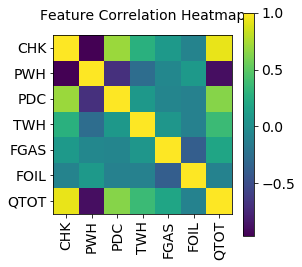

In [62]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Split til training, validation og data set.

### Test data

In [63]:
test_set = df[2000:2500]

x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

### Validation data

In [64]:
train_val_set = df.copy().drop(test_set.index) 
#train_val_set = df.iloc[0:500]

val_set = train_val_set.sample(frac=0.1, replace=False)

x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]

### Training data

In [65]:
train_set = train_val_set.copy().drop(val_set.index)

x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]

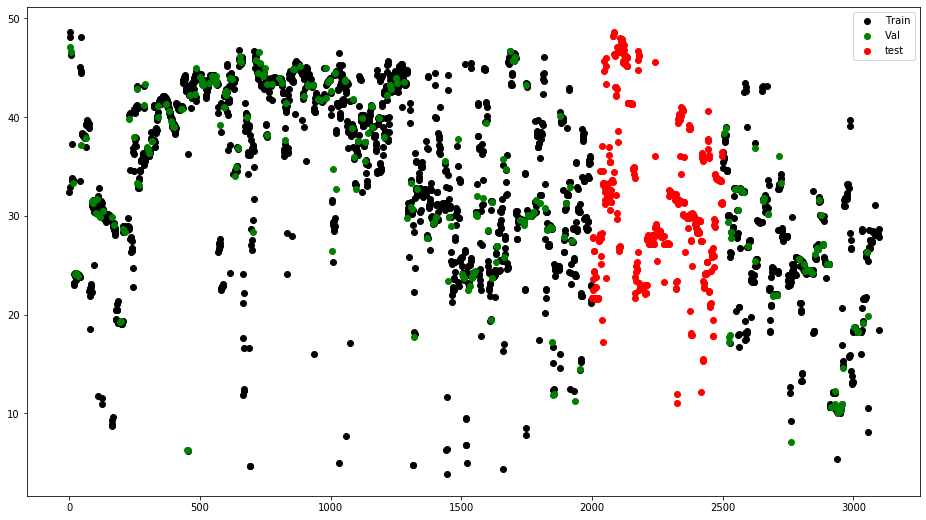

In [66]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Enkel model

- 2 hidden layers
- 6 + 128 + 64 + 1 noder

<img src="neural_network.jpg" width=600>

## Activation function
### Relu

<img src="relu.png" width=500>

Med Keras blir alle vektene initialisert til 0

In [67]:
from keras import regularizers

input_layer_size = x_train.columns.size

model = keras.Sequential()
model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

In [68]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_17 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 9,259
Trainable params: 9,259
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [70]:
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10,verbose=2)

Epoch 1/200
234/234 - 0s - loss: 316.1826 - val_loss: 44.8962
Epoch 2/200
234/234 - 0s - loss: 33.4888 - val_loss: 32.9608
Epoch 3/200
234/234 - 0s - loss: 21.7168 - val_loss: 18.8589
Epoch 4/200
234/234 - 0s - loss: 12.7260 - val_loss: 12.8132
Epoch 5/200
234/234 - 0s - loss: 10.5661 - val_loss: 12.1412
Epoch 6/200
234/234 - 0s - loss: 10.2527 - val_loss: 11.1951
Epoch 7/200
234/234 - 0s - loss: 9.9960 - val_loss: 10.5522
Epoch 8/200
234/234 - 0s - loss: 9.5464 - val_loss: 9.9591
Epoch 9/200
234/234 - 0s - loss: 9.1732 - val_loss: 10.1555
Epoch 10/200
234/234 - 0s - loss: 8.8214 - val_loss: 8.9325
Epoch 11/200
234/234 - 0s - loss: 8.3960 - val_loss: 9.4415
Epoch 12/200
234/234 - 0s - loss: 7.9713 - val_loss: 7.9122
Epoch 13/200
234/234 - 0s - loss: 7.4857 - val_loss: 7.5076
Epoch 14/200
234/234 - 0s - loss: 7.2543 - val_loss: 7.1694
Epoch 15/200
234/234 - 0s - loss: 6.8921 - val_loss: 6.9283
Epoch 16/200
234/234 - 0s - loss: 6.6366 - val_loss: 6.8571
Epoch 17/200
234/234 - 0s - loss: 

Epoch 137/200
234/234 - 0s - loss: 4.1389 - val_loss: 4.8208
Epoch 138/200
234/234 - 0s - loss: 4.1975 - val_loss: 4.8354
Epoch 139/200
234/234 - 0s - loss: 4.1810 - val_loss: 5.1444
Epoch 140/200
234/234 - 0s - loss: 4.1455 - val_loss: 5.1789
Epoch 141/200
234/234 - 0s - loss: 4.2871 - val_loss: 4.8122
Epoch 142/200
234/234 - 0s - loss: 4.2285 - val_loss: 5.1010
Epoch 143/200
234/234 - 0s - loss: 4.1665 - val_loss: 4.8588
Epoch 144/200
234/234 - 0s - loss: 4.1967 - val_loss: 4.8009
Epoch 145/200
234/234 - 0s - loss: 4.1926 - val_loss: 4.9894
Epoch 146/200
234/234 - 0s - loss: 4.0762 - val_loss: 4.8004
Epoch 147/200
234/234 - 0s - loss: 4.1529 - val_loss: 5.6334
Epoch 148/200
234/234 - 0s - loss: 4.1960 - val_loss: 4.9901
Epoch 149/200
234/234 - 0s - loss: 4.2141 - val_loss: 5.2881
Epoch 150/200
234/234 - 0s - loss: 4.1040 - val_loss: 4.8241
Epoch 151/200
234/234 - 0s - loss: 4.0530 - val_loss: 4.7342
Epoch 152/200
234/234 - 0s - loss: 4.1065 - val_loss: 4.7353
Epoch 153/200
234/234 - 

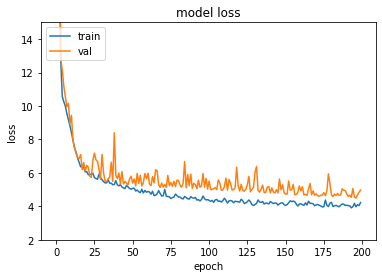

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([2,15])
plt.show()

In [72]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [73]:

print("Error on test data simple model")
mse_test_simple = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_simple) #2.6873526

mae_test_simple = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test_simple) # 1.12

mape_test_simple = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_simple, "%") # 3.574



Error on test data simple model
MSE:  4.159488293072967
MAE:  1.5145783286851529
MAPE:  4.498216319181288 %


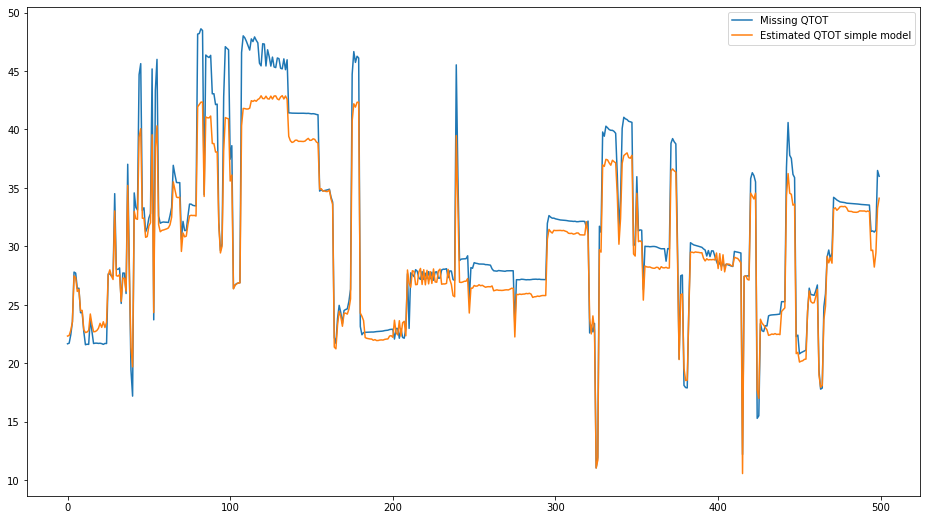

In [83]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.legend()

# Ny model

### Legge til dropout lag

In [93]:
from keras.layers import Dropout

input_layer_size = x_train.columns.size

improved_model = keras.Sequential()
improved_model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
improved_model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(1))

In [94]:
improved_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________


In [95]:
improved_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Early stopping

In [96]:
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

callback = EarlyStopping(monitor='val_loss', patience=6)


improved_history = improved_model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/200
234/234 - 0s - loss: 962.8948 - val_loss: 640.0084
Epoch 2/200
234/234 - 0s - loss: 293.0987 - val_loss: 97.7464
Epoch 3/200
234/234 - 0s - loss: 72.5890 - val_loss: 75.1896
Epoch 4/200
234/234 - 0s - loss: 60.6876 - val_loss: 63.5397
Epoch 5/200
234/234 - 0s - loss: 49.7678 - val_loss: 50.9659
Epoch 6/200
234/234 - 0s - loss: 38.6583 - val_loss: 38.5852
Epoch 7/200
234/234 - 0s - loss: 28.1665 - val_loss: 27.5555
Epoch 8/200
234/234 - 0s - loss: 19.6707 - val_loss: 19.1007
Epoch 9/200
234/234 - 0s - loss: 13.9908 - val_loss: 14.4458
Epoch 10/200
234/234 - 0s - loss: 10.9815 - val_loss: 11.5047
Epoch 11/200
234/234 - 0s - loss: 9.5561 - val_loss: 10.5456
Epoch 12/200
234/234 - 0s - loss: 8.7339 - val_loss: 9.4473
Epoch 13/200
234/234 - 0s - loss: 8.1185 - val_loss: 9.0242
Epoch 14/200
234/234 - 0s - loss: 7.6975 - val_loss: 8.4541
Epoch 15/200
234/234 - 0s - loss: 7.3653 - val_loss: 8.0754
Epoch 16/200
234/234 - 0s - loss: 7.1635 - val_loss: 7.7032
Epoch 17/200
234/234 - 0s

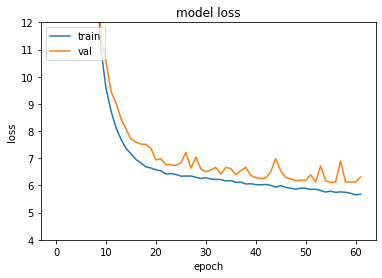

In [97]:
plt.plot(improved_history.history['loss'])
plt.plot(improved_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([4,12])
plt.show()

In [98]:
improved_keras_predictions = improved_model.predict(x_test, verbose=2)

16/16 - 0s


In [99]:

print("Error on test data improved model")
mse_test_improved = np.mean(np.power(improved_keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_improved) #2.6873526

mae_test_improved = np.mean(np.abs(improved_keras_predictions-y_test.values))
print("MAE: ", mae_test_improved) # 1.12

mape_test_improved = 100*np.mean(np.abs(np.divide(improved_keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_improved, "%") # 3.574



Error on test data improved model
MSE:  2.246453079136794
MAE:  1.0125294272984324
MAPE:  3.1853669150968495 %


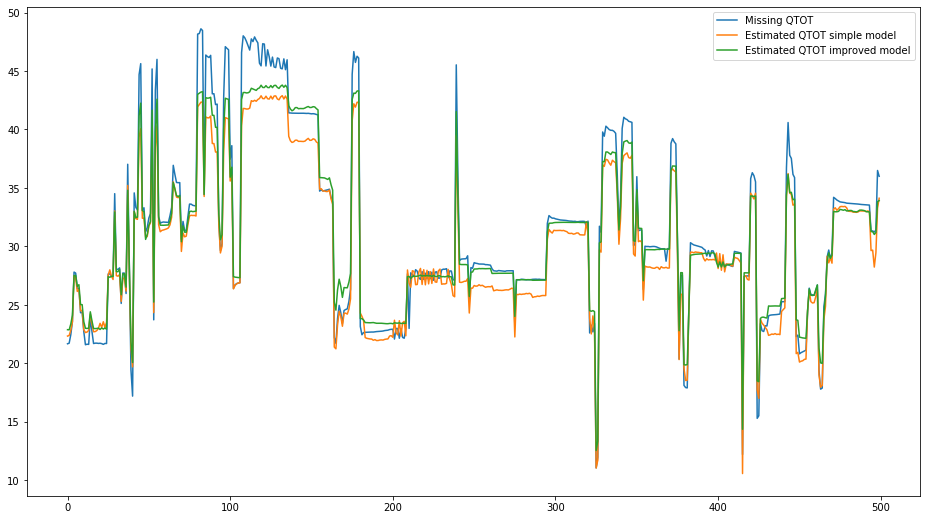

In [100]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.plot(improved_keras_predictions, label='Estimated QTOT improved model')
plt.legend()

In [101]:
import numpy as np
from tabulate import tabulate

m = np.array([["MSE", mse_test_simple, mse_test_improved],["MAE", mae_test_simple, mae_test_improved ],["MAPE", mape_test_simple, mape_test_improved]]);

headers = ["old", "new"]

table = tabulate(m, headers, tablefmt="fancy_grid")

print(table)


╒══════╤═════════╤═════════╕
│      │     old │     new │
╞══════╪═════════╪═════════╡
│ MSE  │ 4.15949 │ 2.24645 │
├──────┼─────────┼─────────┤
│ MAE  │ 1.51458 │ 1.01253 │
├──────┼─────────┼─────────┤
│ MAPE │ 4.49822 │ 3.18537 │
╘══════╧═════════╧═════════╛
